In [2]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display, Math, Latex
from matplotlib import pyplot as plt
import re
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
import random

In [1]:
import pandas as pd
import numpy as np
import random
from catboost import CatBoostRegressor

# Глобальная фиксация для всех библиотек
SEED = 322
random.seed(SEED)
np.random.seed(SEED)

def calculate_iou(lower_true, upper_true, lower_pred, upper_pred, epsilon=1e-6):
    intersection = np.maximum(0, np.minimum(upper_true, upper_pred) - np.maximum(lower_true, lower_pred))
    union = (upper_true - lower_true + epsilon) + (upper_pred - lower_pred + epsilon) - intersection
    return np.mean(intersection / union)

# 1. ЗАГРУЗКА
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train = train[train['price_p05'] > 0]
train['dt'] = pd.to_datetime(train['dt'])
test['dt'] = pd.to_datetime(test['dt'])

# 2. FEATURE ENGINEERING
def create_smart_features(df, train_ref=None):
    if train_ref is not None:
        prod_price_map = train_ref.groupby('product_id')['price_p05'].mean().to_dict()
        df['global_prod_avg'] = df['product_id'].map(prod_price_map)
        cat_price_map = train_ref.groupby('third_category_id')['price_p05'].mean().to_dict()
        df['global_cat_avg'] = df['third_category_id'].map(cat_price_map)
    
    cat_stores_map = df.groupby('third_category_id')['n_stores'].transform('mean')
    df['store_density_ratio'] = df['n_stores'] / (cat_stores_map + 1e-6)
    df['temp_hum_index'] = df['avg_temperature'] * (df['avg_humidity'] / 100)
    df['category_breadth'] = df.groupby(['dt', 'third_category_id'])['product_id'].transform('nunique')
    
    # --- НОВЫЕ ФИЧИ ---
    # Близость к границам месяца (1-е и 31-е числа)
    df['days_to_side'] = df['dt'].dt.day.apply(lambda x: min(x, 31 - x))
    
    # Взаимодействие Категория + Акция
    df['cat_promo'] = df['first_category_id'].astype(str) + "_" + df['activity_flag'].astype(str)
    
    return df

train = create_smart_features(train, train_ref=train)
test = create_smart_features(test, train_ref=train)

# 3. ЦИКЛИЧЕСКИЕ ПРИЗНАКИ
def add_cyclical_features(df):
    df['dow_sin'] = np.sin(2 * np.pi * df['dow'] / 7)
    df['dow_cos'] = np.cos(2 * np.pi * df['dow'] / 7)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    return df

train = add_cyclical_features(train)
test = add_cyclical_features(test)

# 4. СПИСОК ПРИЗНАКОВ
# Добавляем cat_promo в список категориальных
cat_features = ['management_group_id', 'first_category_id', 'activity_flag', 'cat_promo']

features = [
    'n_stores', 'precpt', 'avg_temperature', 'avg_humidity', 
    'avg_wind_level', 'week_of_year', 'month_sin', 'month_cos',
    'global_prod_avg', 'global_cat_avg', 'store_density_ratio',
    'temp_hum_index', 'category_breadth', 'days_to_side'
] + cat_features

# Заполняем NaN (numeric only, категориальные CatBoost обработает сам или заполним строкой)
train[features] = train[features].fillna(train[features].mean(numeric_only=True))
test[features] = test[features].fillna(train[features].mean(numeric_only=True))

# 5. ВАЛИДАЦИЯ / КАЛИБРОВКА
train_parts, val_parts = [], []
for _, group in train.groupby('dt'):
    group = group.sample(frac=1, random_state=SEED).reset_index(drop=True)
    split_idx = int(len(group) * 0.8)
    train_parts.append(group.iloc[:split_idx])
    val_parts.append(group.iloc[split_idx:])

train_part = pd.concat(train_parts)
val_part = pd.concat(val_parts)

# ПАРАМЕТРЫ CatBoost (Optuna)
best_optuna_params = {
    'learning_rate': 0.09981859399773757, 
    'depth': 7, 
    'l2_leaf_reg': 8.533654459953857, 
    'random_strength': 1.3535330397123693, 
    'bagging_temperature': 0.757231412091197
}

cb_params = {
    'iterations': 3000,
    'random_seed': SEED,
    'verbose': 100,
    'early_stopping_rounds': 200,
    **best_optuna_params
}

print("Обучение моделей для расчета калибровки...")
model_low = CatBoostRegressor(loss_function='MAE', **cb_params)
model_high = CatBoostRegressor(loss_function='MAE', **cb_params)

model_low.fit(train_part[features], train_part['price_p05'], 
              eval_set=(val_part[features], val_part['price_p05']), 
              cat_features=cat_features, use_best_model=True)

model_high.fit(train_part[features], train_part['price_p95'], 
               eval_set=(val_part[features], val_part['price_p95']), 
               cat_features=cat_features, use_best_model=True)

# --- БЛОК: ПОИСК ЛУЧШЕГО ALPHA ЧЕРЕЗ IoU ---
print("\nПоиск оптимального alpha на валидации...")
calib_preds_low = model_low.predict(val_part[features])
calib_preds_high = model_high.predict(val_part[features])

nonconf_low = calib_preds_low - val_part['price_p05']
nonconf_high = val_part['price_p95'] - calib_preds_high

best_alpha = 0.1
best_iou = -1
best_q = (0, 0)

for a in np.linspace(0.1, 0.9, 81): 
    ql = np.quantile(nonconf_low, 1 - a/2)
    qh = np.quantile(nonconf_high, 1 - a/2)
    
    p05_corr = calib_preds_low - ql
    p95_corr = calib_preds_high + qh
    p95_corr = np.maximum(p95_corr, p05_corr + 0.001)
    
    current_iou = calculate_iou(
        val_part['price_p05'].values, 
        val_part['price_p95'].values, 
        p05_corr, 
        p95_corr
    )
    
    if current_iou > best_iou:
        best_iou = current_iou
        best_alpha = a
        best_q = (ql, qh)

q_low, q_high = best_q
print(f"Лучший Alpha: {best_alpha:.3f}")
print(f"Лучший IoU на валидации: {best_iou:.4f}")
print(f"Поправки: q_low = {q_low:.4f}, q_high = {q_high:.4f}\n")

# 6. ФИНАЛЬНОЕ ОБУЧЕНИЕ
print("Обучение финальных моделей на полном датасете...")
final_params_low = cb_params.copy()
final_params_low['iterations'] = model_low.get_best_iteration() + 1
final_params_low.pop('early_stopping_rounds', None)

final_params_high = cb_params.copy()
final_params_high['iterations'] = model_high.get_best_iteration() + 1
final_params_high.pop('early_stopping_rounds', None)

final_low = CatBoostRegressor(loss_function='MAE', allow_writing_files=False, **final_params_low)
final_high = CatBoostRegressor(loss_function='MAE', allow_writing_files=False, **final_params_high)

final_low.fit(train[features], train['price_p05'], cat_features=cat_features, verbose=100)
final_high.fit(train[features], train['price_p95'], cat_features=cat_features, verbose=100)

# 7. ПРЕДСКАЗАНИЕ С КОРРЕКТИРОВКОЙ
print("Создание предсказаний...")
test['price_p05'] = final_low.predict(test[features]) - q_low
test['price_p95'] = final_high.predict(test[features]) + q_high

test['price_p95'] = np.maximum(test['price_p95'], test['price_p05'] + 0.001)

submission = test[['row_id', 'price_p05', 'price_p95']].sort_values('row_id')
submission.to_csv('submission_optimized_v2.csv', index=False)
print(f"Готово! Скорректировано с alpha={best_alpha:.3f}.")

Обучение моделей для расчета калибровки...
0:	learn: 0.1426537	test: 0.1344798	best: 0.1344798 (0)	total: 166ms	remaining: 8m 17s
100:	learn: 0.0864066	test: 0.0929436	best: 0.0925435 (45)	total: 2.93s	remaining: 1m 24s
200:	learn: 0.0816384	test: 0.0930908	best: 0.0925435 (45)	total: 5.83s	remaining: 1m 21s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.0925434751
bestIteration = 45

Shrink model to first 46 iterations.
0:	learn: 0.0987503	test: 0.0928766	best: 0.0928766 (0)	total: 26.5ms	remaining: 1m 19s
100:	learn: 0.0813246	test: 0.0887103	best: 0.0882391 (72)	total: 2.79s	remaining: 1m 20s
200:	learn: 0.0764425	test: 0.0893604	best: 0.0882391 (72)	total: 5.46s	remaining: 1m 16s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.0882390698
bestIteration = 72

Shrink model to first 73 iterations.

Поиск оптимального alpha на валидации...
Лучший Alpha: 0.570
Лучший IoU на валидации: 0.2789
Поправки: q_low = 0.0510, q_high = 0.0292

Обучение фи

In [13]:
# идеи - признаки через стандартные отклонения и т д в разных разрезах?
# обучение нейросети + conformal + кастомный лосс Pinball + coverage penalty для нейросети 

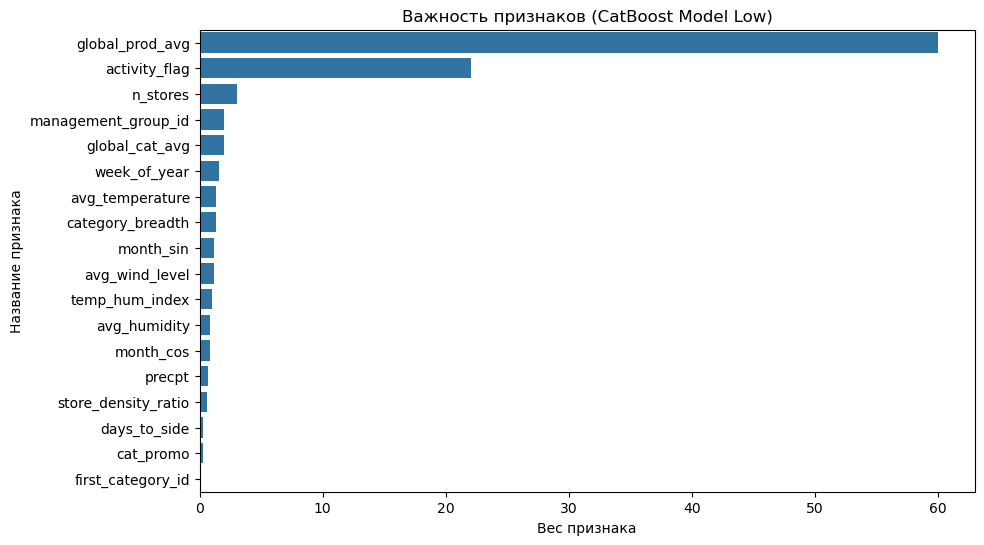

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# Получаем данные
feature_importance = final_low.get_feature_importance(prettified=True)

# Строим график
plt.figure(figsize=(10, 6))
sns.barplot(x="Importances", y="Feature Id", data=feature_importance)
plt.title('Важность признаков (CatBoost Model Low)')
plt.xlabel('Вес признака')
plt.ylabel('Название признака')
plt.show()